# Train FCN for semantic segmentation

You must only define model structure and choose loss function

After model will work, optionally add some augmentation to improve results

## Load the data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.



In [1]:
# ! wget http://fmb.images.gan4x4.ru/hse/midv500p.zip
# ! unzip -q midv500p.zip

Dataloader.
You can use it without modification

In [3]:
import random
from torch.utils.data import Dataset
import glob
from PIL import Image
import torch
import numpy as np

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(432)


class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.files = glob.glob(path + "/image/*")
        self.masks = glob.glob(path + "/mask/*")
        self.files.sort()
        self.masks.sort()
        self.transform = transform

    def __getitem__(self, i):
        im = Image.open(self.files[i])
        mask = Image.open(self.masks[i]).convert('1')  # Load mask in B/W format
        if self.transform:
            im = self.transform(im)
            mask = self.transform(mask)
        return im, mask

    def __len__(self):
        return len(self.files)

Dataloaders initialization

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_dataset = MaskDataset('data/train',
                            transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = MaskDataset('data/val',
                          transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Lets show some data

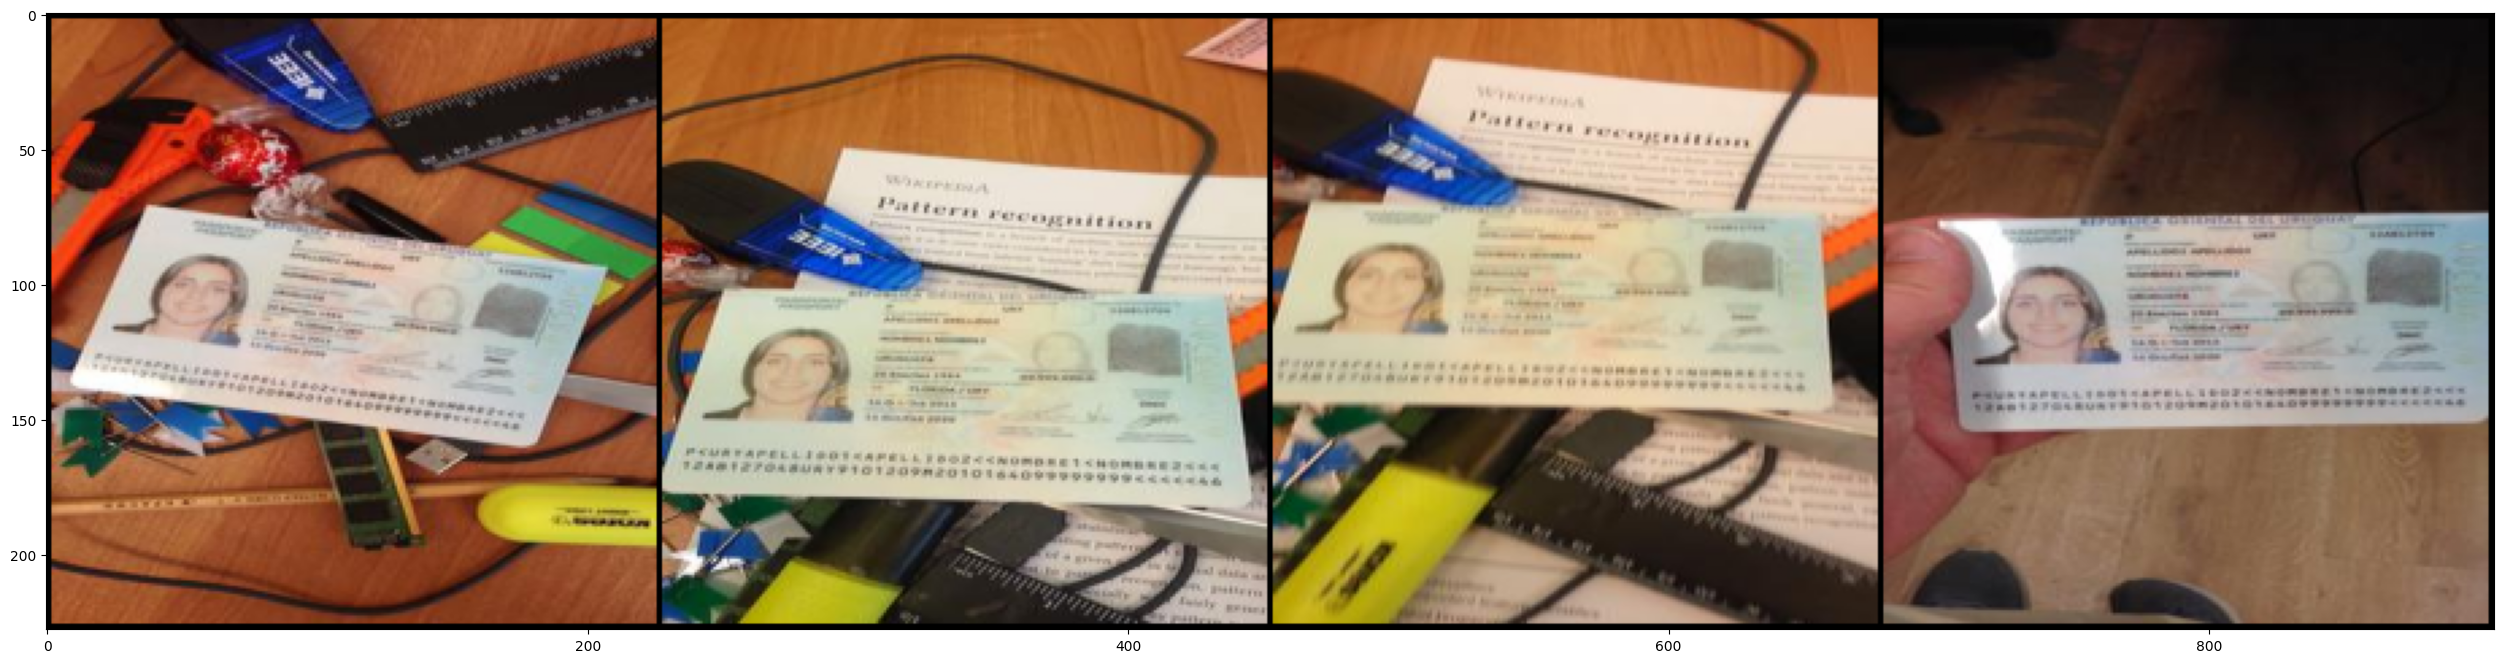

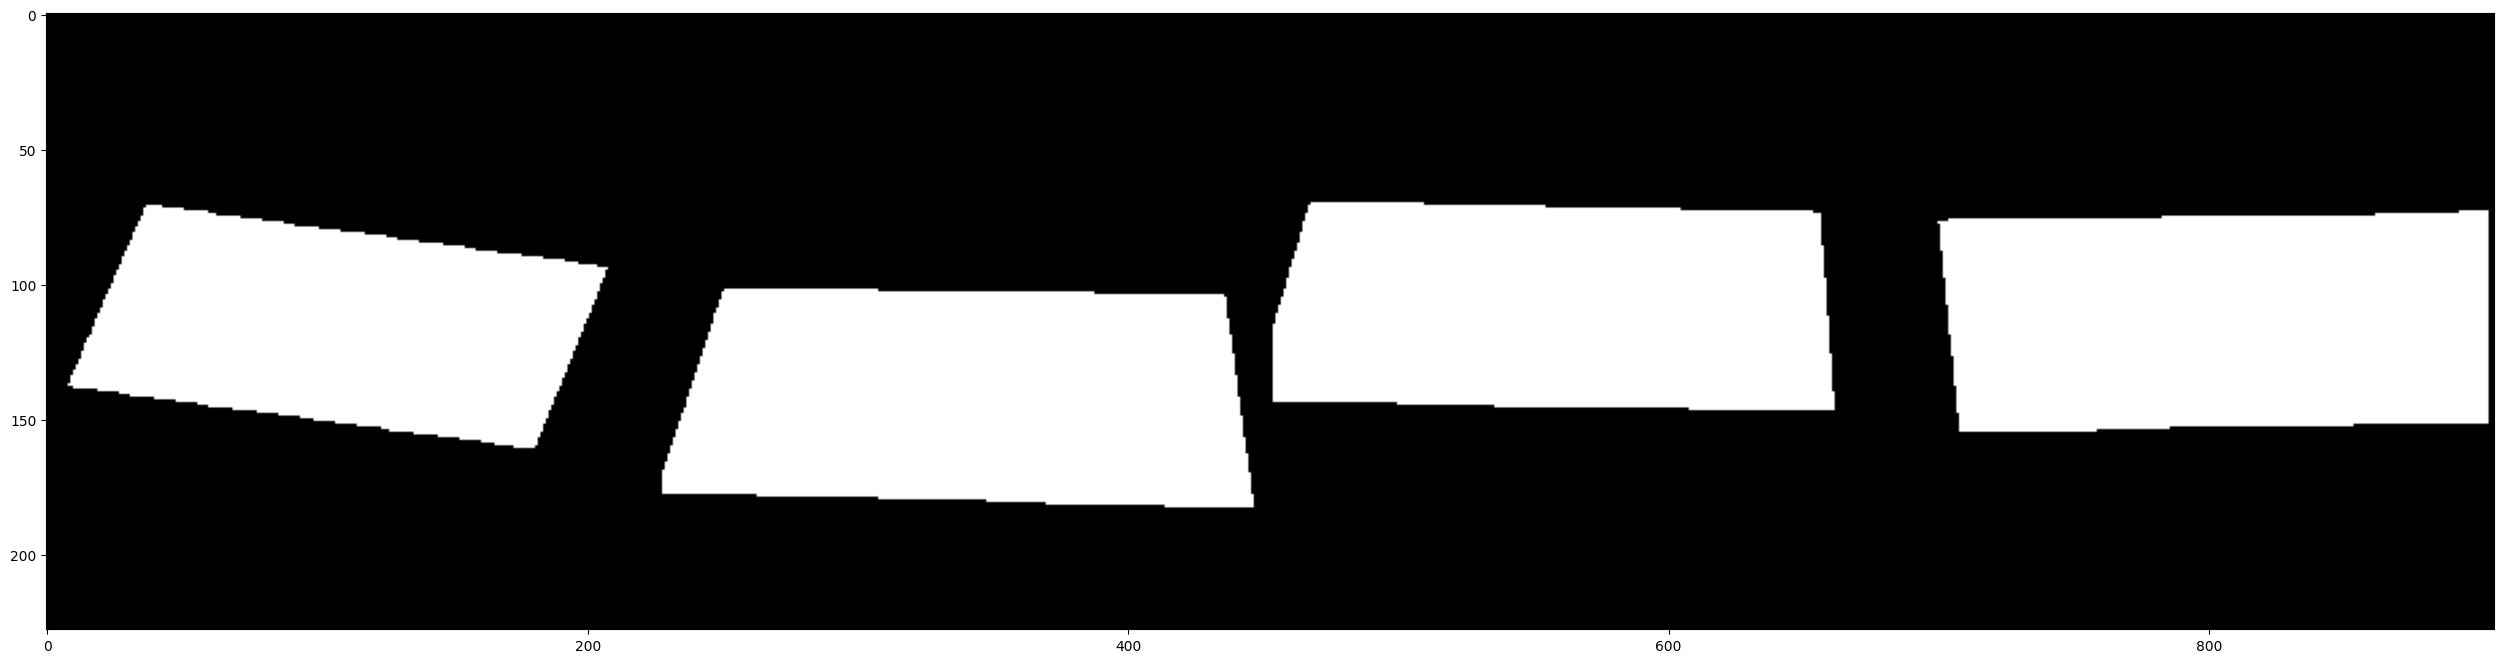

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (40, 8)
%matplotlib inline

def show(batch):
    # create grid of images
    # https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
    img_grid = make_grid(batch)
    plt.figure()
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))


images, masks = next(iter(val_loader))

show(images)
show(masks)

Tensorboard init helper

In [6]:
# import os
# import shutil
#
#
# def reinit_tensorboard(clear_log=True):
#     # Directory for log files
#     logs_base_dir = "runs"
#     if clear_log:
#         # Clear logs
#         shutil.rmtree(logs_base_dir, ignore_errors=True)
#         os.makedirs(logs_base_dir, exist_ok=True)
#     # Colab magic
#     % load_ext tensorboard
#     % tensorboard --logdir {logs_base_dir}

In [7]:
images.shape

torch.Size([4, 3, 224, 224])

In [8]:
import wandb

wandb.login()
wandb.init(project="cv-unet", entity="dmitysh")

wandb: Currently logged in as: dmitysh. Use `wandb login --relogin` to force relogin


# Code for train

You must select Loss function

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(model):
    model.train()
    model.to(device)

    criterion = BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(50):
        train_loss = 0
        for img_batch, masks_batch in train_loader:
            optimizer.zero_grad()
            output = model(img_batch.to(device))
            loss = criterion(output, masks_batch.to(device))
            train_loss += loss.cpu().item()
            loss.backward()
            optimizer.step()

        """
        Write data to wandb
        """
        wandb.log({"epoch": epoch,
                   "train loss": train_loss})
        print("Epoch {} Train loss {}".format(epoch, train_loss))

## Define your model sttructure here

Use [UNet](https://arxiv.org/pdf/1505.04597.pdf) - like structure.
But  decrease number of layers for simplicity.
Original images has 224x224 resolution.

In [10]:
from torch.nn import *


def two_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )


def crop(tensor, target):
    target_size = target.size()[2]
    tensor_size = tensor.size()[2]

    delta = (tensor_size - target_size) // 2

    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]


class MiniUnet(Module):
    def __init__(self, num_classes):
        super(MiniUnet, self).__init__()
        self.down1 = two_conv(3, 64)
        self.down2 = two_conv(64, 128)
        self.down3 = two_conv(128, 256)
        self.down_mp2 = nn.MaxPool2d(2)

        self.up_trans1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv1 = two_conv(256, 128)
        self.up_trans2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv2 = two_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down_mp2(x1)
        x3 = self.down2(x2)
        x4 = self.down_mp2(x3)
        x5 = self.down3(x4)

        x = self.up_trans1(x5)
        y = crop(x3, x)
        x = self.up_conv1(torch.cat([x, y], 1))

        x = self.up_trans2(x)
        y = crop(x1, x)
        x = self.up_conv2(torch.cat([x, y], 1))

        out = self.out(x)

        return out

## Train the model

In [11]:
# reinit_tensorboard()
model = MiniUnet(1).to(device)
train(model)



Epoch 0 Train loss 13.897956818342209
Epoch 1 Train loss 9.822042644023895
Epoch 2 Train loss 9.573510900139809
Epoch 3 Train loss 9.116929948329926
Epoch 4 Train loss 8.440890371799469
Epoch 5 Train loss 8.460189633071423
Epoch 6 Train loss 8.133115626871586
Epoch 7 Train loss 7.9719425812363625
Epoch 8 Train loss 7.364739626646042
Epoch 9 Train loss 7.2830800563097
Epoch 10 Train loss 6.874007008969784
Epoch 11 Train loss 6.424510166049004
Epoch 12 Train loss 6.1375443786382675
Epoch 13 Train loss 6.297941893339157
Epoch 14 Train loss 5.989886894822121
Epoch 15 Train loss 5.327252566814423
Epoch 16 Train loss 5.670041099190712
Epoch 17 Train loss 5.027361057698727
Epoch 18 Train loss 4.908179670572281
Epoch 19 Train loss 4.162526436150074
Epoch 20 Train loss 4.872107230126858
Epoch 21 Train loss 4.146096285432577
Epoch 22 Train loss 3.724595509469509
Epoch 23 Train loss 3.2691437788307667
Epoch 24 Train loss 3.086002081632614
Epoch 25 Train loss 3.0907858833670616
Epoch 26 Train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


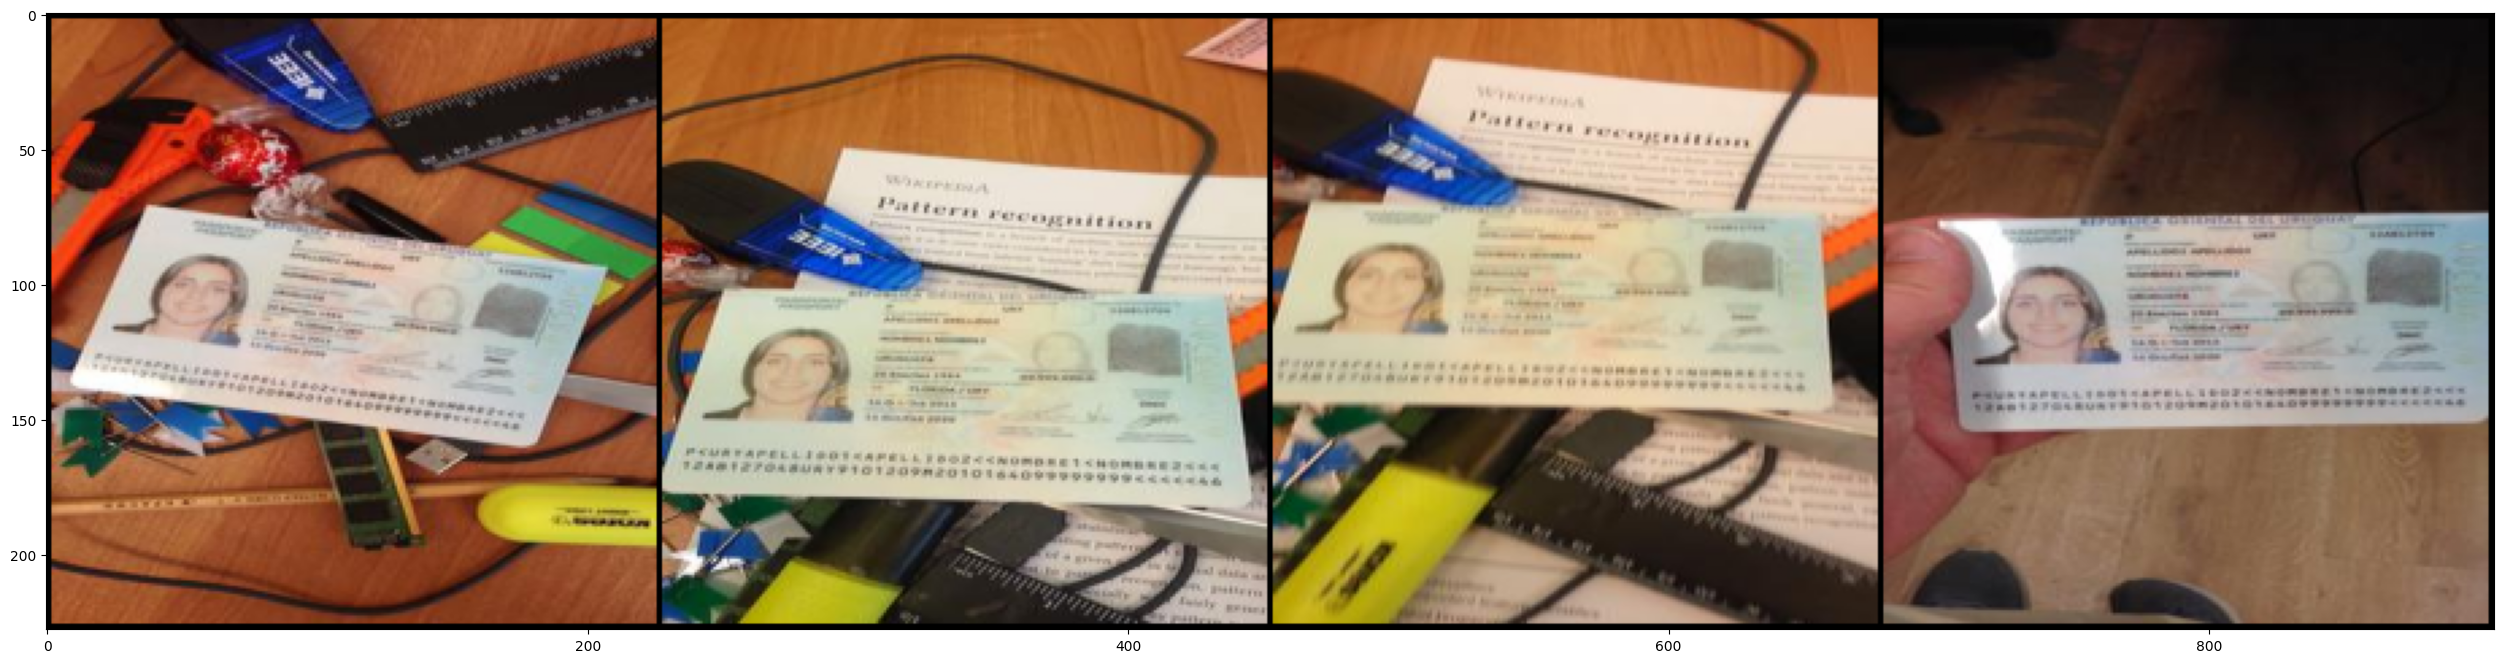

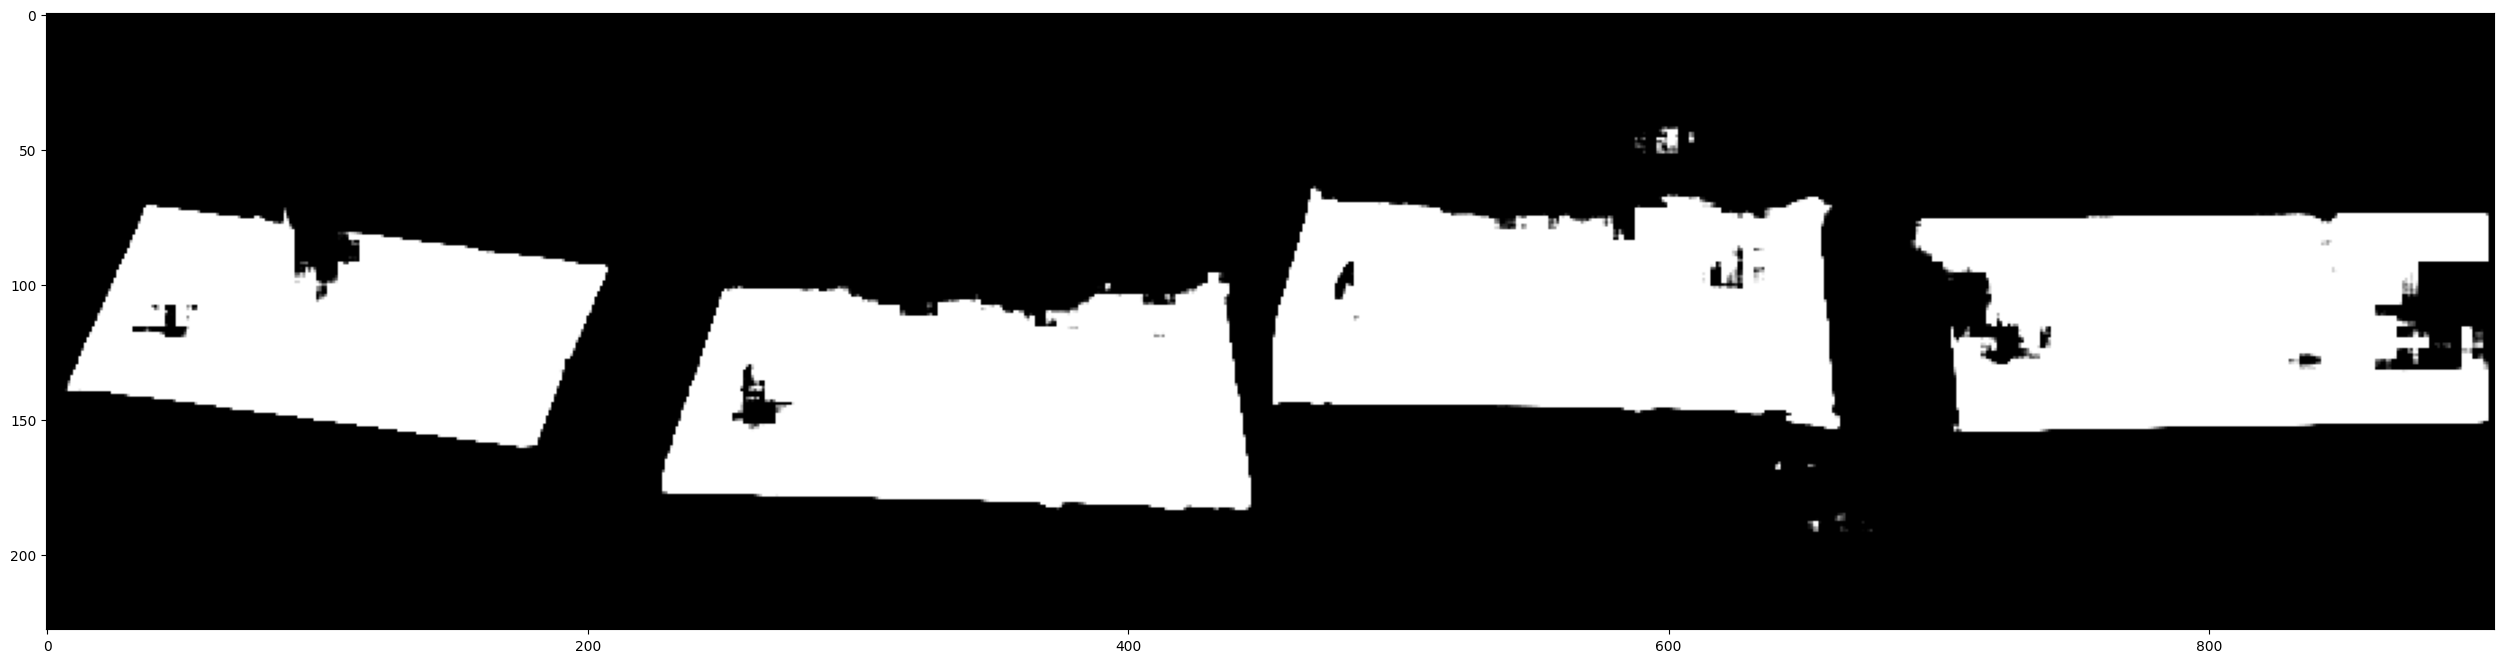

In [12]:
dataiter = iter(val_loader)
images, masks = next(dataiter)

res = model(images.to(device))
show(images)
show(res.cpu())

### Conclusion
- Реализовал Unet mini
- Выбрал лосс BCEWithLogits
- Подсмотрел у араба как правильно делать конкатенации в Unet
- Поднял число эпох до 50



## Wandb
https://wandb.ai/dmitysh/cv-unet?workspace=user-dmitysh

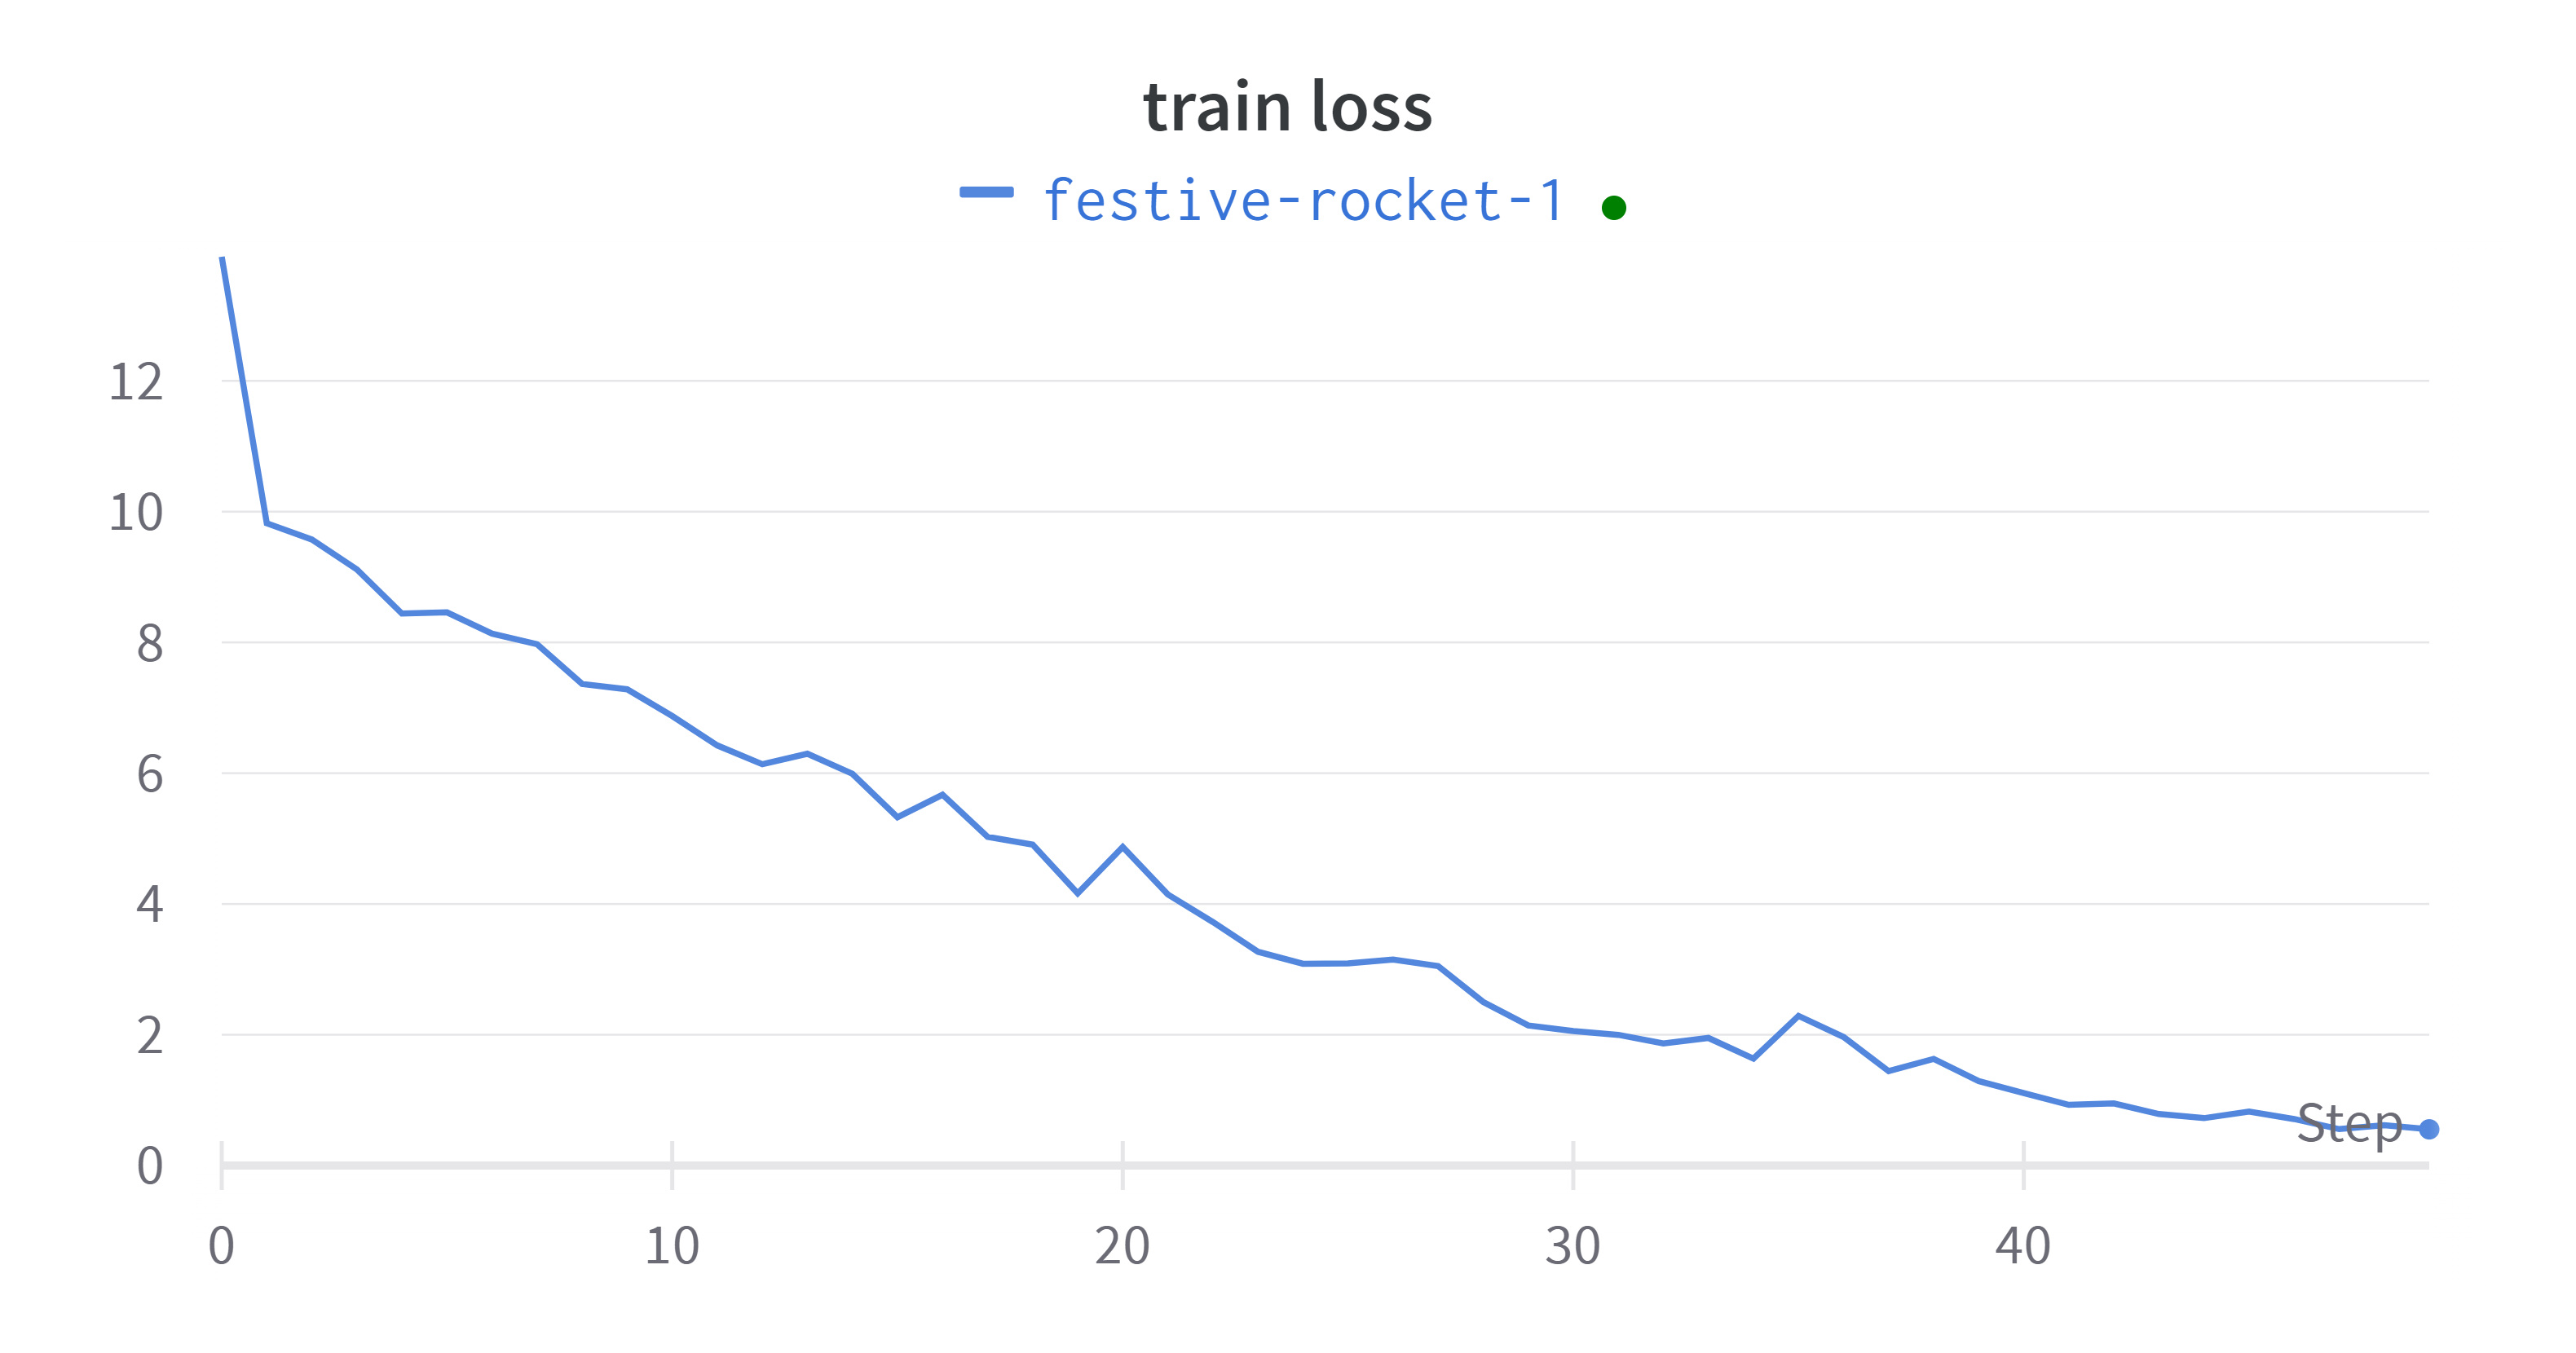

In [13]:
from IPython.display import Image
Image('img/train_loss.png')